# Gensim SE LDA Tutorial

If you need more structure and detail please review my chapter on applying LDA to Software Engineering Texts

http://webdocs.cs.ualberta.ca/~hindle1/2016/06Hindle.pdf

1. The first task involves acquiring the issue-tracker data and representing itin a convenient format such as JSON.
2. Then we transform the text of the input data, namely we convert the textto word counts, where words are represented as integer IDs.
3. We apply LDA software on the transformed documents to produce a topic-document matrix and a topic-word matrix.
4. We then summarize the top words from the topic-word matrix to produce topic-word summaries and store the topic-document matrix.
5. Finally, we analyze the document matrix and the topics. The objective of this analysis step is to (a) examine the latent topics discovered; (b)plot the topic relevance over time; and (c) cluster the issues (i.e., inputdocuments) according to their associated topics.


# Other references

RUN LDA Gensim Tutorial by Radim Řehůřek https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

In [1]:
import gensim
import json
import numpy
import numpy as np
import scipy
import matplotlib
import github 
import os
# pip3 install --user PyGithub gensim scipy numpy matplotlib
issues = []

# 4.2 Acquiring Data

You can skip this part if you have an existing `large.json`


In [2]:
config = json.load(open("config.json"))
USERNAME= os.environ.get("GHUSERNAME", config.get("GHUSERNAME",""))
PASSWORD= os.environ.get("GHPASSWORD", config.get("GHPASSWORD"))
g = github.Github(USERNAME,PASSWORD)
repo = g.get_repo("PyGithub/PyGithub")
print(repo)

Repository(full_name="PyGithub/PyGithub")


In [3]:
max_issues = 2000
issues_iter = repo.get_issues(state="all")
issues = []
count = 0
for issue in issues_iter:
    issues.append(issue)
    count += 1
    if count > max_issues:
        break

print(len(issues))    

1683


In [4]:
print("Max issue number: %s %s" % 
      (max([issue.number for issue in issues]), len(issues)))

Max issue number: 1687 1683


In [5]:
issues[0]
print(issues[0].number)
print(issues[0].title)
print(issues[0].body)

1687
Expanding the PyGithub authorization to support multiple tokens
Heya!

I'm a PhD student that regularly uses PyGithub to gather data for research projects (for instance we used PyGithub to analyze the code review usage and CI usage of ~700 open-source projects, [see this paper for instance](https://cassee.dev/files/CI-silent.pdf)). When using PyGithub to make millions of GET requests over the period  of a few months we often pool the tokens of several researchers involved in the project, and use a scraper that dynamically switches tokens based on actual rate limits. 

However, writing this code is often a pain, as it requires messing with the internals of PyGithub. Recently, I started working on an update to PyGithub that allows you to pass in a list of tokens instead of a single token. Internally, PyGithub then does the switching of tokens, abstracting it away. 

However, I'm not sure if this feature is of interest to more users of PyGithub. If so, I'm open to discussing on how I

In [6]:
def blank_none(v):
    if v is None:
        return ""
    return v
rows = [{"doc":{"_id":issue.number, "title":issue.title, "content":blank_none(issue.body)}}
        for issue in issues]
large_json = {"rows":rows}
json.dump(large_json,open("pylarge.json","w"))

# 4.3. Text Analysis and Data Transformation

* Loading text
* Transforming text
* Lexical analysis of text
* Optionally removing stop words
* Optionally stemming
* Optionally removing uncommon or very common words
* Building a vocabulary 
* Transforming each text document into a word-bag / word-vector


# Loading Text

In [7]:
ALPHA=0.01
BETA=0.01
PASSES=10
TOPICS=20
INPUT="large.json"

def read_json_file( filename ):
    jsonsdata = open(filename).read()
    data = json.loads(jsonsdata)
    return read_json_data( data )

def read_json_data( data ):
    ldocs = [ row["doc"] for row in data["rows"] ]
    docs = {}
    for doc in ldocs:
        docs[doc["_id"]] = doc
    ids = [ doc["_id"] for doc in ldocs ]
    ids.sort()
    return  docs, ids

def text_summary(document):
    if (document is None):
        document = {}
    return document.get("title","") + " \n" + document.get("content","")



In [8]:
if len(issues) > 0:
    print("Using PyGithub")
    ldocs, lids = read_json_data( large_json )
else:
    print("Loading %s" % INPUT)
    ldocs, lids = read_json_file( INPUT )


Using PyGithub


In [9]:
ldocs[lids[-1]]

{'_id': 1687,
 'title': 'Expanding the PyGithub authorization to support multiple tokens',
 'content': "Heya!\r\n\r\nI'm a PhD student that regularly uses PyGithub to gather data for research projects (for instance we used PyGithub to analyze the code review usage and CI usage of ~700 open-source projects, [see this paper for instance](https://cassee.dev/files/CI-silent.pdf)). When using PyGithub to make millions of GET requests over the period  of a few months we often pool the tokens of several researchers involved in the project, and use a scraper that dynamically switches tokens based on actual rate limits. \r\n\r\nHowever, writing this code is often a pain, as it requires messing with the internals of PyGithub. Recently, I started working on an update to PyGithub that allows you to pass in a list of tokens instead of a single token. Internally, PyGithub then does the switching of tokens, abstracting it away. \r\n\r\nHowever, I'm not sure if this feature is of interest to more user

In [10]:
text_summary(ldocs[lids[50]])

'Docs seem to be out of sync with code? \nHi!\nBack again. :-) I started playing around with 1.1, and it seems many things happened in the meantime. \nFor one, the docs seem to be out of sync with the code. For example, get_issues seems to return a PaginatedList, but I can\'t find a mention of that class in the /doc folder. \n\nBackground: With the old version, I got a list of all the issues (open & closed) by saying\n\n```\n Issues=repo.get_issues(state=\'open\') + repo.get_issues(state=\'closed\')\n```\n\nThis worked perfectly well with the method returning normal lists, but running my code now, it complains about `TypeError: unsupported operand type(s) for +: \'instance\' and \'instance\'`\nAlso, later on I hit the issue that `PaginatedList instance has no attribute \'__len__\'` when I want to count the number of issues with `len(Issues)` as worked before.\n\nI realize that this is maybe not a proper issue report, since I\'m asking how to do stuff, but I don\'t see where/how else I 

# Transforming Text

In [11]:
# Get the text content out
texts = [text_summary(ldocs[lid]) for lid in lids]


* Lexical analysis of text
* Optionally removing stop words
* Optionally stemming
* Optionally removing uncommon or very common words
* Building a vocabulary 

## Remove Stop Words

In [12]:
# Make the vocabulary

from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords # removing stop words
from gensim.parsing.preprocessing import preprocess_string # splitting 
from gensim.corpora.dictionary import Dictionary # build vocabulary

# remove stop words and lowercase

texts = [remove_stopwords(text.lower()) for text in texts]
for i in range(10):
    print(i, " ", texts[i])


0   gitub -> github
1   use objects instead string shas, ids, etc. arguments
2   deduce mandatory parameters
3   review public interface homogeneity attributes method parameters identified documented type
4   implement api
5   review exceptions policy receiving error http status
6   publish version 0.4
7   publish version 0.5
8   publish version 1.0 check `todo`s code check 100% test coverage
9   separate githubobjects.py files


# Splitting documents into tokens

In [13]:
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric

# Note preprocess will stem by default, I just want to demonstrate stemming seperately

CUSTOM_FILTERS = [strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]

tokenized = [preprocess_string(text, CUSTOM_FILTERS) for text in texts]

for i in range(10):
    print(i, " ", tokenized[i])

# Note that URLs are messed up by this


0   ['gitub', 'github']
1   ['use', 'objects', 'instead', 'string', 'shas', 'ids', 'etc', 'arguments']
2   ['deduce', 'mandatory', 'parameters']
3   ['review', 'public', 'interface', 'homogeneity', 'attributes', 'method', 'parameters', 'identified', 'documented', 'type']
4   ['implement', 'api']
5   ['review', 'exceptions', 'policy', 'receiving', 'error', 'http', 'status']
6   ['publish', 'version']
7   ['publish', 'version']
8   ['publish', 'version', 'check', 'todo', 's', 'code', 'check', 'test', 'coverage']
9   ['separate', 'githubobjects', 'py', 'files']


## Stemming

In [14]:
# Stemming doesn't always help
stemmer = PorterStemmer()

def stem_document(p,doc):
    return [p.stem(word) for word in doc]

stemmed = [stem_document(stemmer,doc) for doc in tokenized]

for i in range(10):
    print(i, " ", stemmed[i])
    
# # disable stemming
stemmed = tokenized

0   ['gitub', 'github']
1   ['us', 'object', 'instead', 'string', 'sha', 'id', 'etc', 'argument']
2   ['deduc', 'mandatori', 'paramet']
3   ['review', 'public', 'interfac', 'homogen', 'attribut', 'method', 'paramet', 'identifi', 'document', 'type']
4   ['implement', 'api']
5   ['review', 'except', 'polici', 'receiv', 'error', 'http', 'statu']
6   ['publish', 'version']
7   ['publish', 'version']
8   ['publish', 'version', 'check', 'todo', 's', 'code', 'check', 'test', 'coverag']
9   ['separ', 'githubobject', 'py', 'file']


# Building a Vocabulary

In [15]:
vocab = Dictionary( stemmed )
print(len(vocab))


5935


## Optionally removing uncommon or very common words

In [16]:
vocab.filter_extremes(no_below=2, no_above=0.5)
print(len(vocab))


2970


# Transforming each text document into a word-bag / word-vector

In [17]:
# Convert documents into bag of words representation

corpus = [vocab.doc2bow(doc) for doc in stemmed]
print("(ID,COUNT)")
print(corpus[0])
print("Should be 4 of 1 word")
print(vocab.doc2bow(['asset','asset','asset','asset','png']))

print(len(corpus))

for i in range(10):
    print(i, " ", corpus[i])

(ID,COUNT)
[]
Should be 4 of 1 word
[(1708, 1), (1785, 4)]
1683
0   []
1   [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]
2   [(7, 1), (8, 1)]
3   [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]
4   [(16, 1), (17, 1)]
5   [(14, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]
6   [(24, 1), (25, 1)]
7   [(24, 1), (25, 1)]
8   [(24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)]
9   [(32, 1), (33, 1), (34, 1), (35, 1)]


# 4.4. Applying LDA

In [18]:
dumb_dictionary_bug = vocab[0]
id2word = vocab.id2token
lda = gensim.models.LdaModel(
    corpus,
    num_topics=TOPICS,
    id2word=id2word,
    passes=PASSES,
    alpha=ALPHA,
    eval_every=5,
    eta=BETA
)

# Summarize top topic words

In [19]:
from pprint import pprint
num_words = 10

chars = 12
template = "%" + str(chars) + "." + str(chars) + "s"

def top_topics_report(lda, corpus, num_words):
    top_topics = lda.top_topics(corpus, topn=num_words)
    rows = []
    i = 0
    for topic in top_topics:
        rows.append(("%3d" % i) + " ".join([template % topic[0][i][1] for i in range(num_words)]))
        i += 1
    report = "\n".join(rows)
    return report, top_topics

report, top_topics = top_topics_report(lda, corpus, num_words)
pprint(top_topics)
print(report)

[([(0.06095727, 'self'),
   (0.05068822, 'py'),
   (0.043452013, 'line'),
   (0.04188814, 'file'),
   (0.037869573, 'lib'),
   (0.037591033, 'python'),
   (0.02874243, 'packages'),
   (0.027426649, 'url'),
   (0.022227816, 'site'),
   (0.0215803, 'requester')],
  -0.682073870842474),
 ([(0.05454333, 'self'),
   (0.036544677, 'py'),
   (0.030536074, 'python'),
   (0.029262464, 'lib'),
   (0.027393267, 'file'),
   (0.026500681, 'packages'),
   (0.02308007, 'line'),
   (0.019745683, 'site'),
   (0.019480057, 'url'),
   (0.015511637, 'local')],
  -0.8531591494214076),
 ([(0.046953462, 'file'),
   (0.03771601, 'line'),
   (0.037429858, 'py'),
   (0.0303763, 'python'),
   (0.025002988, 'repo'),
   (0.02304277, 'get'),
   (0.019454362, 'packages'),
   (0.017218858, 'site'),
   (0.01658209, 'lib'),
   (0.015632985, 'create')],
  -1.0480750705891086),
 ([(0.07220732, 'x'),
   (0.02366523, 'com'),
   (0.022517687, 'api'),
   (0.021542216, 'ratelimit'),
   (0.02107529, 'https'),
   (0.01794594, '

In [20]:
report, top_topics = top_topics_report(lda, corpus, num_words)
print(report)

  0        self           py         line         file          lib       python     packages          url         site    requester
  1        self           py       python          lib         file     packages         line         site          url        local
  2        file         line           py       python         repo          get     packages         site          lib       create
  3           x          com          api    ratelimit        https      content         type        oauth          url       origin
  4       https          com     pygithub         pull       branch       create            v      request          api     required
  5         get     pygithub            i   repository        https           io         html      objects            t  readthedocs
  6        team        teams          add organization          get      members   membership        tests          org         user
  7     release    developer          com            v       delete  

# Associate Documents with Topics

In [21]:
for i in range(10):
    doc_lda = lda[corpus[i]]
    print("%-40.40s" % str(doc_lda) + " | " + texts[i])

[(0, 0.05), (1, 0.05), (2, 0.05), (3, 0. | gitub -> github
[(16, 0.973609)]                         | use objects instead string shas, ids, etc. arguments
[(1, 0.9136306)]                         | deduce mandatory parameters
[(3, 0.5835744), (9, 0.3944711)]         | review public interface homogeneity attributes method parameters identified documented type
[(10, 0.9136355)]                        | implement api
[(11, 0.32785133), (12, 0.6471436)]      | review exceptions policy receiving error http status
[(5, 0.91363555)]                        | publish version 0.4
[(5, 0.91363555)]                        | publish version 0.5
[(5, 0.9793471)]                         | publish version 1.0 check `todo`s code check 100% test coverage
[(5, 0.2916276), (17, 0.66550463)]       | separate githubobjects.py files


In [22]:
import gensim.matutils
sparse_document_topics = [lda[doc] for doc in corpus]
document_topics = gensim.matutils.corpus2dense( sparse_document_topics, num_terms = TOPICS )
document_topics


array([[0.05      , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05      , 0.        , 0.9136306 , ..., 0.        , 0.        ,
        0.        ],
       [0.05      , 0.        , 0.        , ..., 0.        , 0.01481386,
        0.        ],
       ...,
       [0.05      , 0.        , 0.        , ..., 0.25227714, 0.3844047 ,
        0.16365473],
       [0.05      , 0.        , 0.        , ..., 0.        , 0.        ,
        0.1746639 ],
       [0.05      , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [24, 12]
plt.rcParams["image.aspect"] = 'auto' 

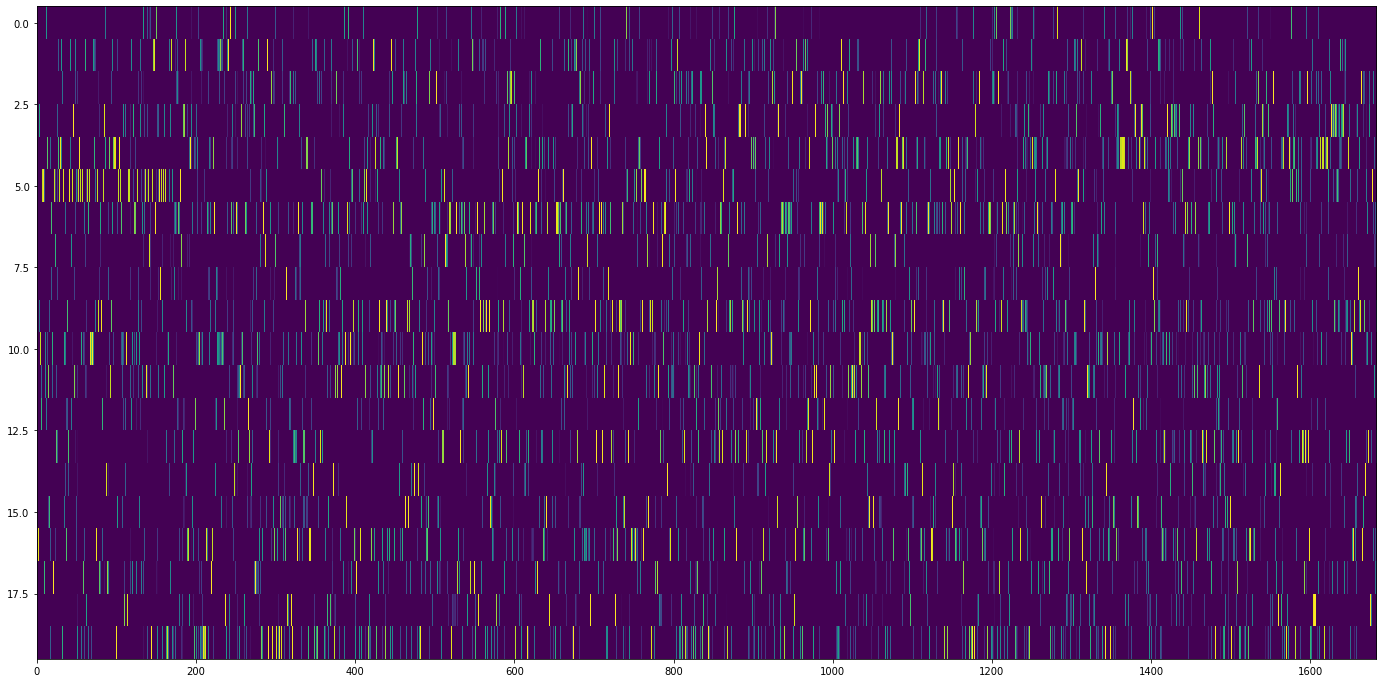

In [39]:
plt.imshow(document_topics, interpolation='none')
plt.show()


(1683,)
(20, 1683)


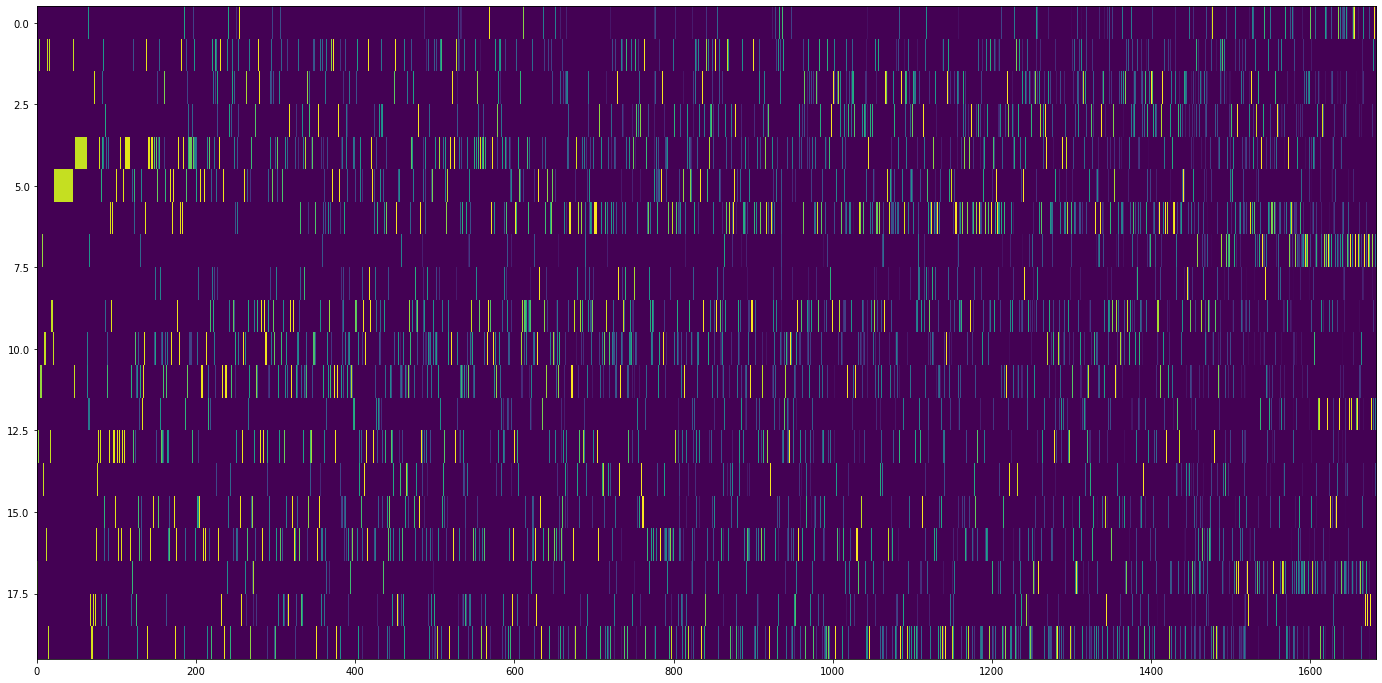

In [40]:
# indices = np.arange(document_topics.shape[1])
sumsort = numpy.argsort(numpy.sum(document_topics,axis=0))
print(sumsort.shape)
print(document_topics.shape)
plt.imshow(document_topics[0:,sumsort], interpolation='none')
plt.show()



(1, 1683)


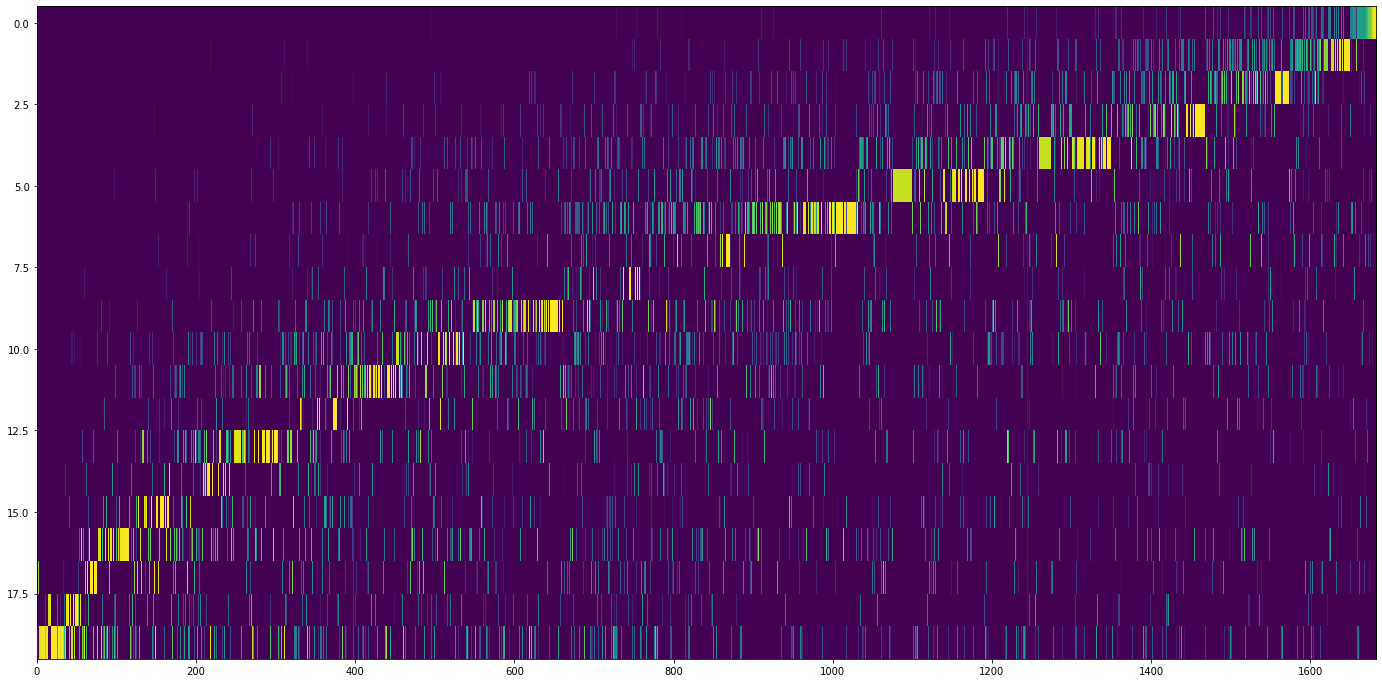

Topic 0
tf better documentation
foo %
fixed small typo
fixed documentation link
added 'stargazers_count' property repository
fix broken links "what's next?"
hexadecimal usernames fail use formatted string literals parsing username
stargazers_count repository stargazers_count property repository class
fix failures % markup. https://github.com/github/github-flavored-markdown/issues/63 prevents error 500 creating issues "%" code block.
write better examples documentation there's way know use you've github api before.
Topic 19
recently random 401 bad credentials exceptions hi, pygithub https://github.com/borkason/google-code-issues-migrator, fork abandoned project, recently random 401 bad credentials exceptions script. exception past, that's think pygithub handles credentials. maybe github changed past 1 2 months? pattern appearance exceptions, yet. think it's random. **this do** authenticate `__main__`: https://github.com/borkason/google-code-issues-migrator/blob/master/migrateissues.py#l

In [41]:
# We're going to weight each topic by its reciprocal and then plot the documents, this is a form of clustering
weights = (1.0/np.arange(1,21))
weights = weights.reshape(1,TOPICS)
dw = np.asarray(numpy.matmul(weights, document_topics))
wsort = numpy.argsort(dw)
print(wsort.shape)
plt.imshow(document_topics[0:,wsort[0,0:]], interpolation='none')
plt.show()
print("Topic 0")
for i in wsort[0,0:10]:
    print(texts[i])
print("Topic 19")
for i in wsort[0,-10:-1]:
    print(texts[i])

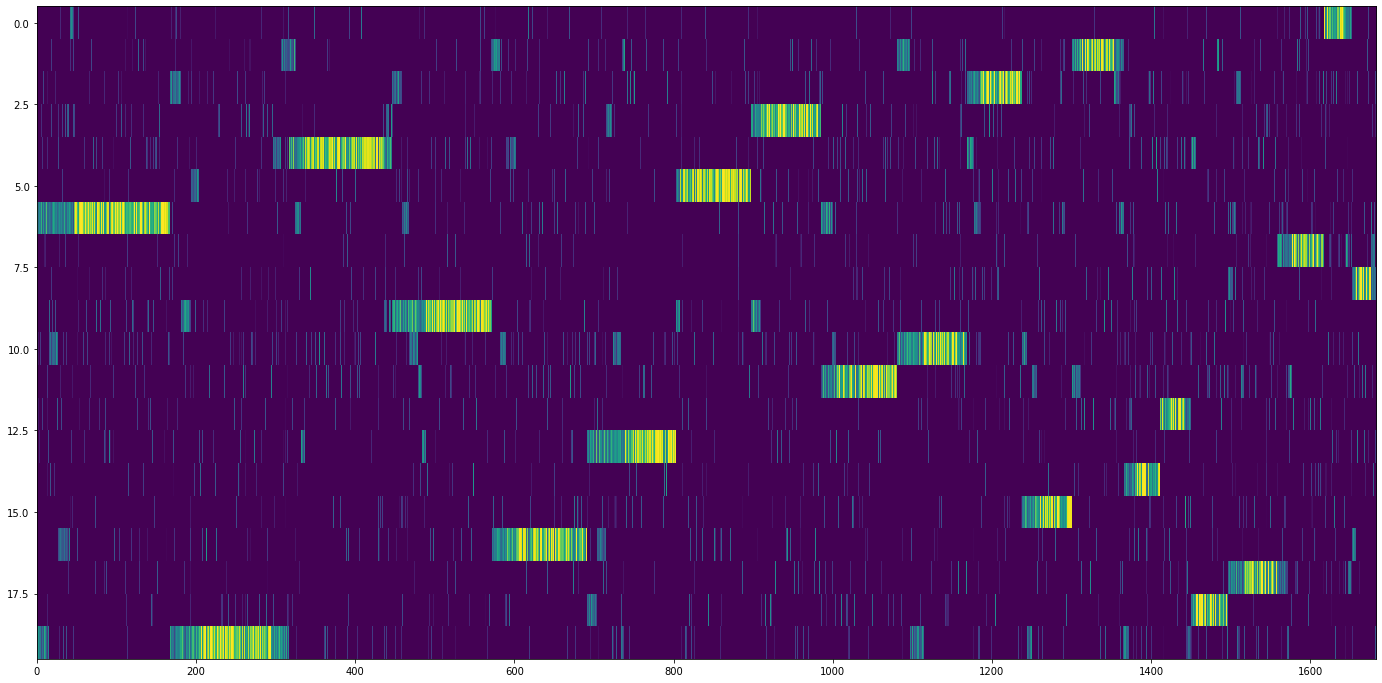

Topic FIRST
tf better documentation
foo %
fixed small typo
fixed documentation link
added 'stargazers_count' property repository
fix broken links "what's next?"
hexadecimal usernames fail use formatted string literals parsing username
stargazers_count repository stargazers_count property repository class
fix failures % markup. https://github.com/github/github-flavored-markdown/issues/63 prevents error 500 creating issues "%" code block.
write better examples documentation there's way know use you've github api before.
Topic LAST
recently random 401 bad credentials exceptions hi, pygithub https://github.com/borkason/google-code-issues-migrator, fork abandoned project, recently random 401 bad credentials exceptions script. exception past, that's think pygithub handles credentials. maybe github changed past 1 2 months? pattern appearance exceptions, yet. think it's random. **this do** authenticate `__main__`: https://github.com/borkason/google-code-issues-migrator/blob/master/migrateissue

In [42]:
# Document Similarity via cosine distance and hierarchical clustering
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
Z = ward(pdist(document_topics.transpose(),'cosine'))
assignment = fcluster(Z, t=0.9, criterion='distance')
indices = numpy.argsort(assignment)
plt.imshow(document_topics[0:,indices], interpolation='none')
plt.show()
print("Topic FIRST")
for i in wsort[0,0:10]:
    print(texts[i])
print("Topic LAST")
for i in wsort[0,-10:-1]:
    print(texts[i])
print("OK let's look at cluster 5")
for i in numpy.argsort(assignment==5)[-10:-1]:
    print(texts[i])


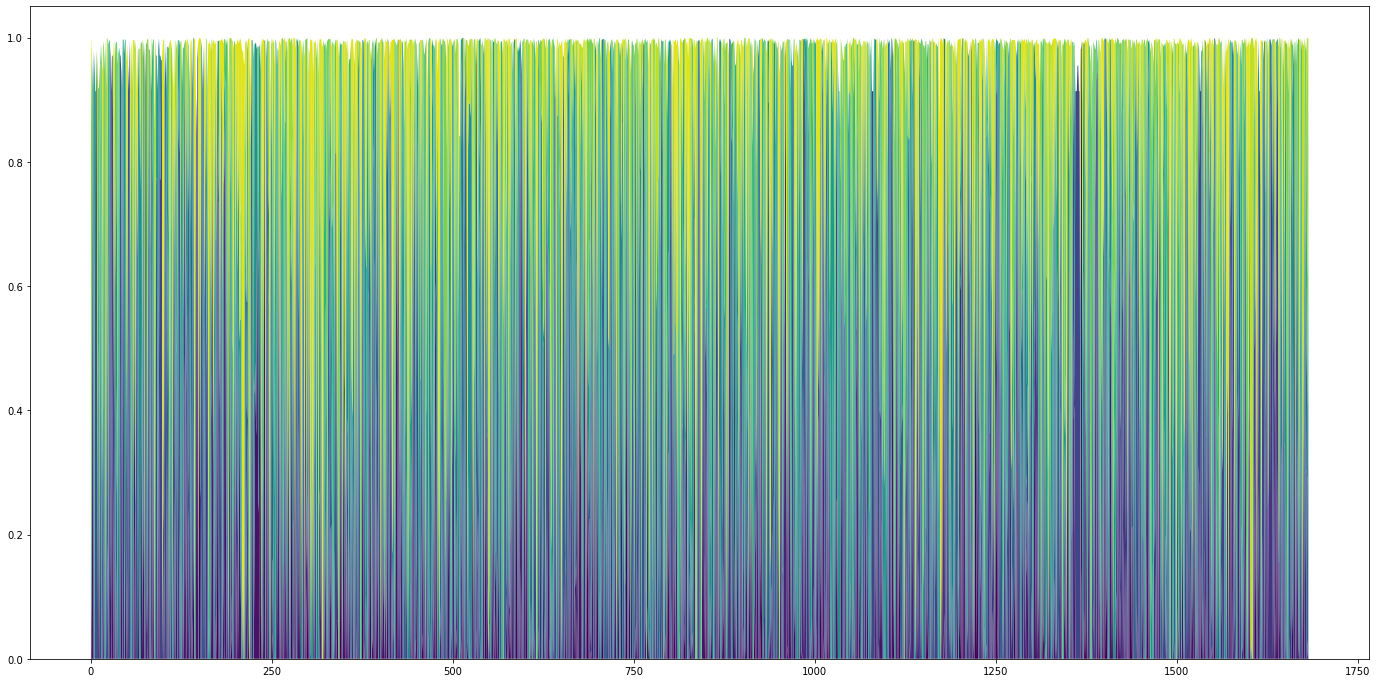

In [43]:
# Stack plot of topics

N = document_topics.shape[1]
ind = np.arange(N)[0:]
colours = plt.cm.viridis([x/TOPICS for x in range(TOPICS)])
plt.stackplot(ind,document_topics[0:,ind],colors=colours)
plt.show()



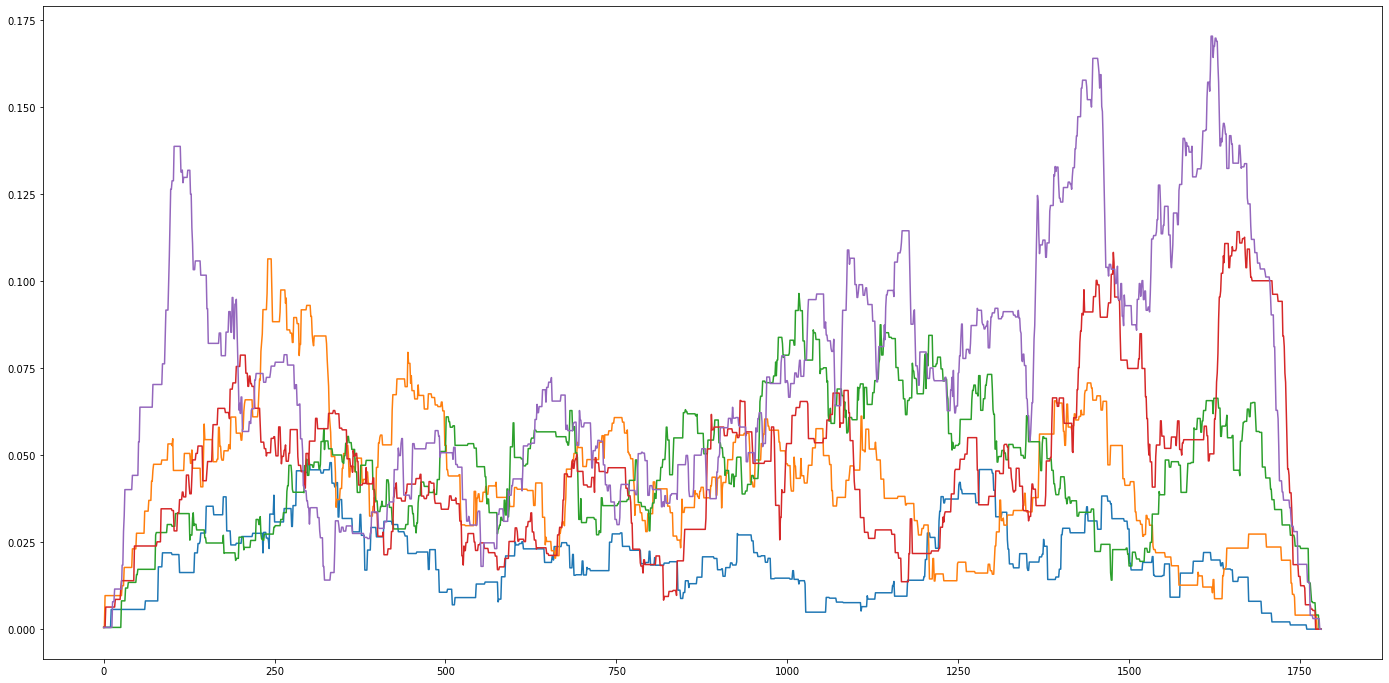

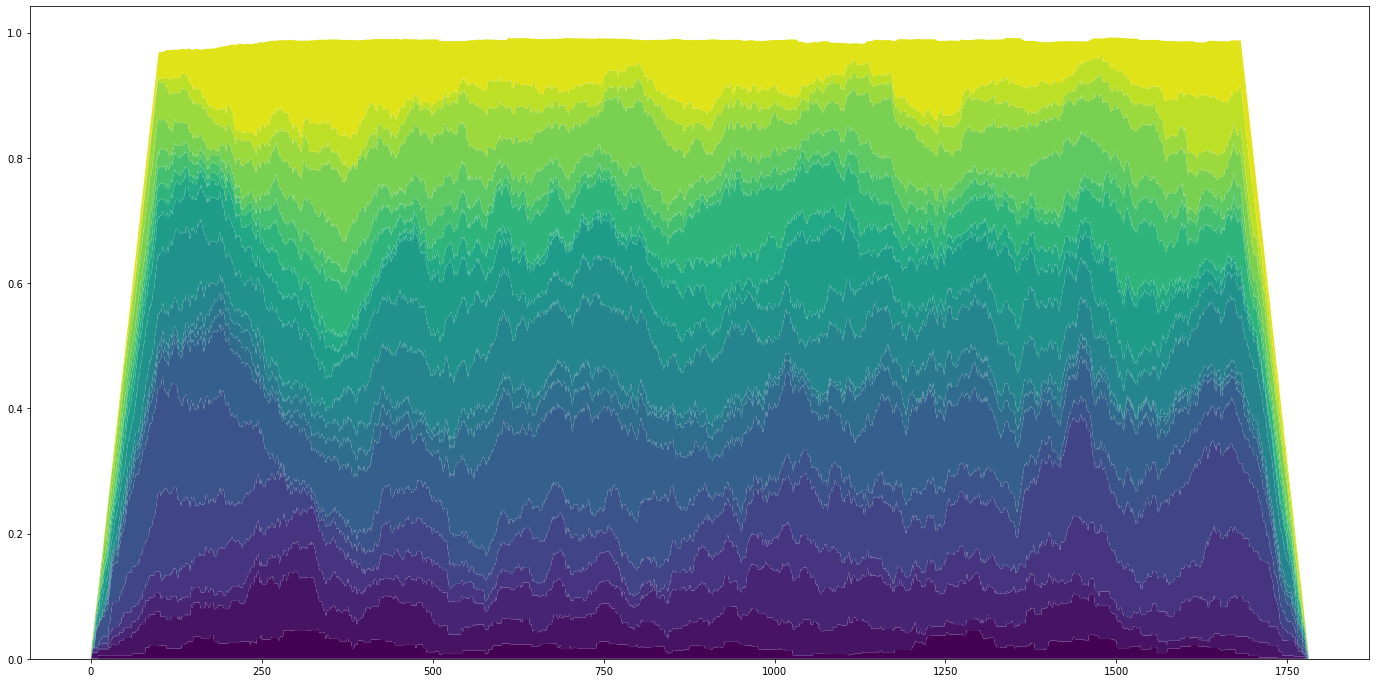

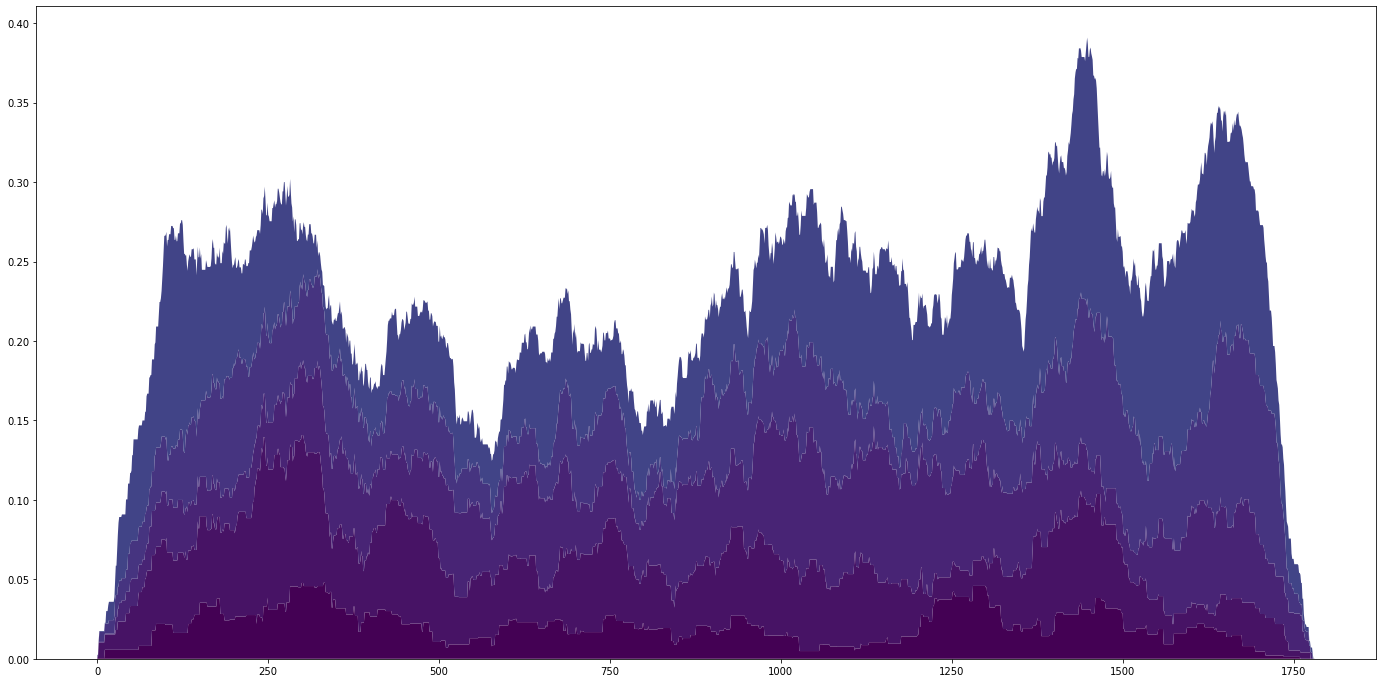

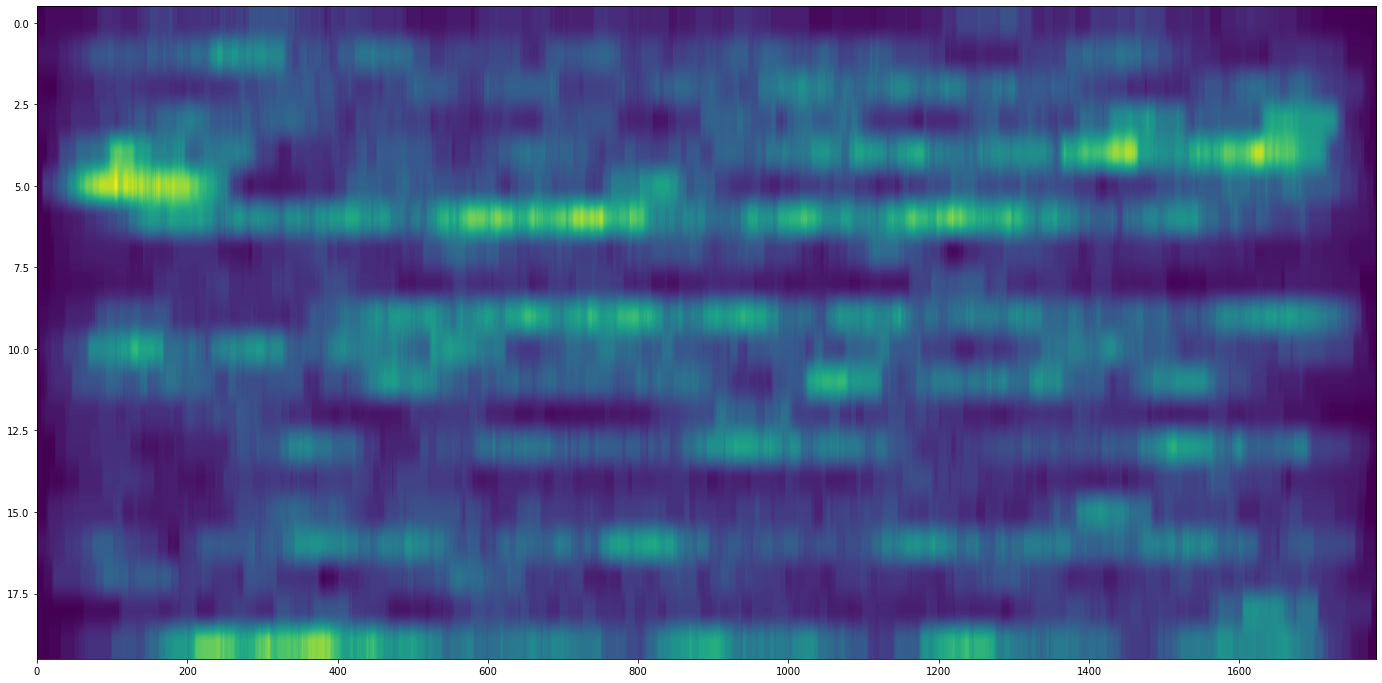

In [44]:
# Topic popularity over time

def moving_average(X,bins):
    length = X.shape[0]
    return np.convolve(X, np.ones(bins)/bins)

N = document_topics.shape[1]
ind = np.arange(N)
for i in range(5):
    plt.plot(moving_average(document_topics[i,ind],100))
plt.show()
mavg = np.array([
    moving_average(document_topics[i,ind],100) for i in range(TOPICS)
])
plt.stackplot(np.arange(mavg.shape[1]),mavg,colors=colours)
plt.show()
plt.stackplot(np.arange(mavg.shape[1]),mavg[0:5,0:],colors=colours)
plt.show()
plt.imshow(mavg)
plt.show()
